## Demystifiying PVN3D dataloader

In [1]:
import numpy as np
from PIL import Image
import cv2
from cv2 import imshow
from matplotlib import pyplot as plt
import pcl

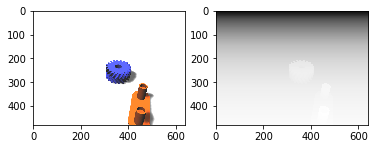

In [14]:
# Load images and display
with Image.open('depth/1.png') as dpt_im:
    dpt = np.array(dpt_im)
    dpt = dpt/65535				#Scaling down between 0 - 3m
    dpt = dpt*3.0


with Image.open('rgb/1.png') as rgb_im:
    rgb = np.array(rgb_im)
    image = rgb

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
plt.imshow(rgb)
ax2 = fig.add_subplot(1, 2, 2)
plt.imshow(dpt, cmap='Greys')
plt.show()

### K - Insintric Matrix 


### Xmap and Ymap

xmap and ymap are 2 dimensional arrays of shape 640 x 480 (same size as input images). xmap contains only the x-indices and ymap contains only the y-indices of the input image

![xmap](xmap.png)
![ymap](ymap.png)

In [3]:
K = np.array([[554.25469119, 0.,         320.5],
              [0.,        554.25469119,  240.5],
              [0.,        0.,         1.]])

xmap = np.array([[j for i in range(640)] for j in range(480)])
ymap = np.array([[i for i in range(640)] for j in range(480)])

### choose 
A 1-dimesional array of containing indexes of all valid points in depth Image. If all the points in depth image are valid then there are 307200 points in a (680 x 480) image.


### cld = pointcloud
A pointcloud is a 2 dimensional array of shape (307200 x 3). They specify the XYZ coordinate for each valid depth point




In [4]:
def dpt_2_cld(xmap,ymap,dpt, K,cam_scale=1):

    if len(dpt.shape) > 2:
        dpt = dpt[:, :, 0]
    msk_dp = dpt > 1e-6
    choose = msk_dp.flatten().nonzero()[0].astype(np.uint32)
    if len(choose) < 1:
        return None, None

    dpt_mskd = dpt.flatten()[choose][:, np.newaxis].astype(np.float32)
    xmap_mskd = xmap.flatten()[choose][:, np.newaxis].astype(np.float32)
    ymap_mskd = ymap.flatten()[choose][:, np.newaxis].astype(np.float32)

    pt2 = dpt_mskd / cam_scale
    cam_cx, cam_cy = K[0][2], K[1][2]
    cam_fx, cam_fy = K[0][0], K[1][1]
    pt0 = (ymap_mskd - cam_cx) * pt2 / cam_fx
    pt1 = (xmap_mskd - cam_cy) * pt2 / cam_fy
    cld = np.concatenate((pt0, pt1, pt2),axis=1)
    
    return cld, choose

cld,choose = dpt_2_cld(xmap,ymap,dpt, K,cam_scale=1)
print(np.shape(cld))
print(cld)
print(np.shape(choose))
print(choose)

(307200, 3)
[[-0.23180455 -0.17394382  0.40086976]
 [-0.23108128 -0.17394382  0.40086976]
 [-0.23035802 -0.17394382  0.40086976]
 ...
 [ 0.05418906  0.04083441  0.09489585]
 [ 0.05436027  0.04083441  0.09489585]
 [ 0.05453148  0.04083441  0.09489585]]
(307200,)
[     0      1      2 ... 307197 307198 307199]


### rgb_pt  
rgb_pt contains the valid rgb points. These are the corresponding rgb values to valid depth points(choose). But its reshaped to a 2 dimensional array of size (307200, 3)


### choose_2
choose_2 is a 1-dimennsional array containing indexes of the array choose. They are equal in length. But if the length is longer than 12288, choose_2 will contain random 12288 indexes from choose. And the lengths are not equal anymore.

In [5]:
n_sample_points = 12288

rgb_lst = []
# rgb ==> channel x length x Height
rgb = np.transpose(rgb, (2, 0, 1))
print(rgb.shape[0])

for ic in range(rgb.shape[0]):
    rgb_lst.append(
        rgb[ic].flatten()[choose].astype(np.float32)
    )

# rgb_list ==> channels x rgbf.flat[choose]    
print('rgb_list', np.shape(rgb_lst))


rgb_pt = np.transpose(np.array(rgb_lst), (1, 0)).copy()
print('rgb_pt', np.shape(rgb_pt))

print('choose_now', choose)
choose = np.array([choose])
choose_2 = np.array([i for i in range(len(choose[0, :]))])
print('choose_2', choose_2)
print('choose_2', np.shape(choose_2))

if len(choose_2) < 400:
    print("Valid points are less than 400")
    

if len(choose_2) > n_sample_points:
    c_mask = np.zeros(len(choose_2), dtype=int)
    c_mask[:n_sample_points] = 1
    np.random.shuffle(c_mask)
    choose_2 = choose_2[c_mask.nonzero()]
    print("Valid points are more than configured")
    
else:
    leng = len(choose_2)
    choose_2 = np.pad(choose_2, (0, n_sample_points-len(choose_2)), 'wrap')
    print("Valid points are optimum")

3
rgb_list (3, 307200)
rgb_pt (307200, 3)
choose_now [     0      1      2 ... 307197 307198 307199]
choose_2 [     0      1      2 ... 307197 307198 307199]
choose_2 (307200,)
Valid points are more than configured


### cld_rgb, cld_2, normal, cld_rgb_nrm , choose

cld_rgb is cld(choose x3)and rgb_pt (choose x 3) stacked vertically?? NO!!.

incorrect details>.
It is a 2 dimensional array of shape (choose x 6). Then cld_rgb is again refined to contain random 12288 points. cld_rgb (12288 x 6 ). For each of the cld normals are calculated and stacked horizontally again. resulting a cld_rgb_norm, a 2 dimensionala array of shape (12288, 9)

In [6]:
cld_rgb = np.concatenate((cld, rgb_pt), axis=1)
print('cld_rgb :', np.shape(cld_rgb))

cld_rgb = cld_rgb[choose_2, :]
print('cld_rgb :', np.shape(cld_rgb))

cld = cld[choose_2, :]


def get_normal( cld):
        cloud = pcl.PointCloud()
        cld = cld.astype(np.float32)
        cloud.from_array(cld)
        ne = cloud.make_NormalEstimation()
        kdtree = cloud.make_kdtree()
        ne.set_SearchMethod(kdtree)
        ne.set_KSearch(50)
        n = ne.compute()
        n = n.to_array()
        return n

normal = get_normal(cld)[:, :3]
normal[np.isnan(normal)] = 0.0
print('normal', np.shape(normal))

cld_rgb_nrm = np.concatenate((cld_rgb, normal), axis=1)

print('cld_rgb_nrm :',np.shape(cld_rgb_nrm))
choose = choose[:, choose_2]
print('choose', np.shape(choose))

cld_rgb : (307200, 6)
cld_rgb : (12288, 6)
normal (12288, 3)
cld_rgb_nrm : (12288, 9)
choose (1, 12288)


### Draw projected pointcloud

(12288, 2)
480 640
(480, 640, 3)
uint8


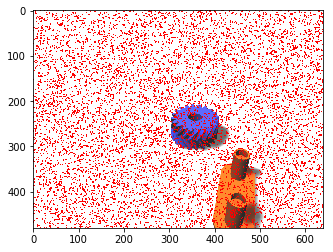

In [15]:
# Projects a 3D pointcloud to 2D (x,y,z -----> X,Y)
def project_p3d( p3d,K,cam_scale=1):
    
    if p3d.shape[1]<4:
        p3d = p3d * cam_scale
        p2d = np.dot(p3d, K.T)
        p2d_3 = p2d[:, 2]
        p2d_3[np.where(p2d_3 < 1e-8)] = 1.0
        p2d[:, 2] = p2d_3
        p2d = np.around((p2d[:, :2] / p2d[:, 2:])).astype(np.int32)
        return p2d

    else:
        p3d = p3d * cam_scale
        #print(p3d.shape)
        print('xyz_rgb points projected to 2D')
        p2d = np.dot(p3d[: , 0:3], K.T)
        p2d_3 = p2d[:, 2]
        filter = np.where(p2d_3 < 1e-8)
        if filter[0].shape[0]>0:
            p2d_rgbs = p3d[filter, 3:6]
            p2d_3[filter] = 1.0
        else:
            p2d_rgbs = p3d[:, 3:6]
        p2d[:, 2] = p2d_3
        p2d = np.around((p2d[:, :2] / p2d[:, 2:])).astype(np.int32)
        #print(p3d.shape)
        #print(p2d.shape)
        return np.concatenate((p2d, p2d_rgbs), axis=1).astype(np.int32)

def draw_p2ds(img, p2ds, color =(255,0,0), rad = 1 ):
    h, w = img.shape[0], img.shape[1]
    for pt_2d in p2ds:
        pt_2d[0] = np.clip(pt_2d[0], 0, w)
        pt_2d[1] = np.clip(pt_2d[1], 0, h)

        if p2ds.shape[1]>2:
                img = cv2.circle(
                    cv2.UMat(img), (pt_2d[0], pt_2d[1]), rad, (int(pt_2d[2]), int(pt_2d[3]), int(pt_2d[4])) , -1
                )
        else:
            img = cv2.circle(cv2.UMat(img), (pt_2d[0], pt_2d[1]), rad, color, -1)
        """
        img = cv2.circle(
            img, (pt_2d[0], pt_2d[1]), rad, color, -1
        )
        """
    return img

# lines to get result

p2ds = project_p3d(cld, K)
print(np.shape(p2ds))
print(rgb.shape[0],rgb.shape[1])
img = draw_p2ds(image,p2ds)
image = img.get()
print(np.shape(image))
print(image.dtype)
plt.imshow(image)


# Data ==> Data_torch